# Model and Evaluation - Predict Sales Price

### objectives

* Fit and evaluate a regression model to predict Sales Price
* Utilise Hyperparameter Optimisation and Grid Search CV to design a well suited and functioning model.

### inputs

* outputs/datasets/cleaned/clean_house_price_records.csv

### Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here.

___

## Change working Directory

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics/jupyter_notebooks'


We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics'

## Load Cleaned Data and Import Necessary Packages

In [5]:

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

from sklearn.decomposition import PCA

import joblib



___

## Load the required cleaned data

Transform the .csv file into a pandas data frame.

In [6]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,1710,Gd,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976,1262,TA,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,1786,Gd,11250,68,162,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998,1717,Gd,9550,60,0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000,2198,Gd,14260,84,350,84,5,8,1145,2000,2000,250000


___

### Define the ML Regressor Pipeline

* The pipeline below implements the feature engineering steps that we concluded on in the previous notebook.

In [7]:
def PipelineOptimisation(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),
        
        ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea',])),
        
        ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                            method="spearman",
                                                            threshold=0.6,
                                                            selection_method="cardinality")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

### Hyperparameter Optimisation

* Below is the Hyperparameter Optimisation function as defined in the Code Institute lesson material relating to Machine Learning.

In [8]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimisation(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


### Grid Search CV - Sklearn.

* We shall use the default hyperparameters to search through the algorithms.

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


* We can now check the results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.676578,0.798403,0.862491,0.071609
2,RandomForestRegressor,0.701255,0.79697,0.844212,0.055843
5,GradientBoostingRegressor,0.608028,0.778348,0.841748,0.088047
0,LinearRegression,0.658521,0.737333,0.822257,0.056768
6,XGBRegressor,0.595537,0.727124,0.775717,0.066604
4,AdaBoostRegressor,0.564369,0.700756,0.751493,0.070433
1,DecisionTreeRegressor,0.312063,0.551501,0.648486,0.122515


* If we return to our business case specifically point 9 "What are the criteria for the performance goal of the predictions?". We can see that the minimum requirement of an r2 score is 0.75.
* If we look at the top 3 algorithms we see that all 3 pass this criteria when we review the mean_score. 
* ExtraTreesRegressor appears to be the best.
* We shall do an extensive search on this algorithm to determine the best hyperparameters. 

In [13]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [50,100,150,200,250,300],
        'model__max_depth': [2,8,16,32,None],
    }
}

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
26,ExtraTreesRegressor,0.678613,0.800873,0.863703,0.071238,None,150
20,ExtraTreesRegressor,0.678613,0.800873,0.863703,0.071238,32,150
14,ExtraTreesRegressor,0.674034,0.79983,0.865461,0.073808,16,150
27,ExtraTreesRegressor,0.678559,0.799437,0.862579,0.071405,None,200
21,ExtraTreesRegressor,0.678559,0.799437,0.862579,0.071405,32,200
17,ExtraTreesRegressor,0.672185,0.799151,0.865493,0.074749,16,300
29,ExtraTreesRegressor,0.675295,0.799046,0.864226,0.072344,None,300
23,ExtraTreesRegressor,0.675295,0.799046,0.864226,0.072344,32,300
13,ExtraTreesRegressor,0.67414,0.798485,0.862944,0.07256,16,100
15,ExtraTreesRegressor,0.67141,0.79846,0.865593,0.07463,16,200


* After an extensive search where I spent time adjusting the values of our Hyperparameters we can clearly see that the  ExtraTreesRegroosr with a max_depth of 32 and an n_estimators of 150 is the most optimised.
* To reitterate the goal was an r2 of 0.75.
* with our tuned Hyperparameters:
    * min r2 = 0.678613 
    * max r2 = 0.863703
    * mean r2 = 0.800873
    * std r2 = 0.071238

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 32, 'model__n_estimators': 150}

___

### Assess feature importance

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea',
                                           'LotArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=32, n_estimators=150,
                                     random_state=0))])

* These are the 6 most important features in descending order. The model was trained on them: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'KitchenQual', 'YearBuilt', 'YearRemodAdd']


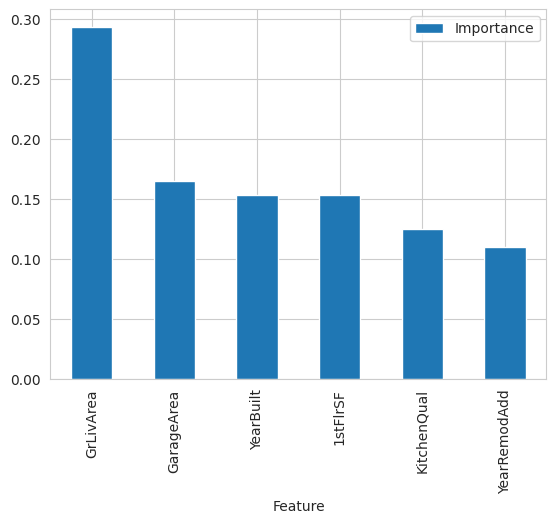

In [19]:
sns.set_style('whitegrid')

%matplotlib inline

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* What this plot shows us is that the 6 most important features needed to determine SalesPrice are as follows:
    * GrLivArea
    * GarageArea
    * YearBuilt
    * 1stFlrSf
    * KitchenQual
    * YearRemodAdd


___

### Evaluate Pipeline Performace on Train and Test sets

In [20]:
def rgs_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	rgs_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	rgs_evaluation(X_test,y_test,pipeline)

def rgs_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def rgs_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 138.289
Mean Squared Error: 947914.048
Root Mean Squared Error: 973.609


* Test Set
R2 Score: 0.847
Mean Absolute Error: 21292.305
Mean Squared Error: 1053381483.713
Root Mean Squared Error: 32455.839




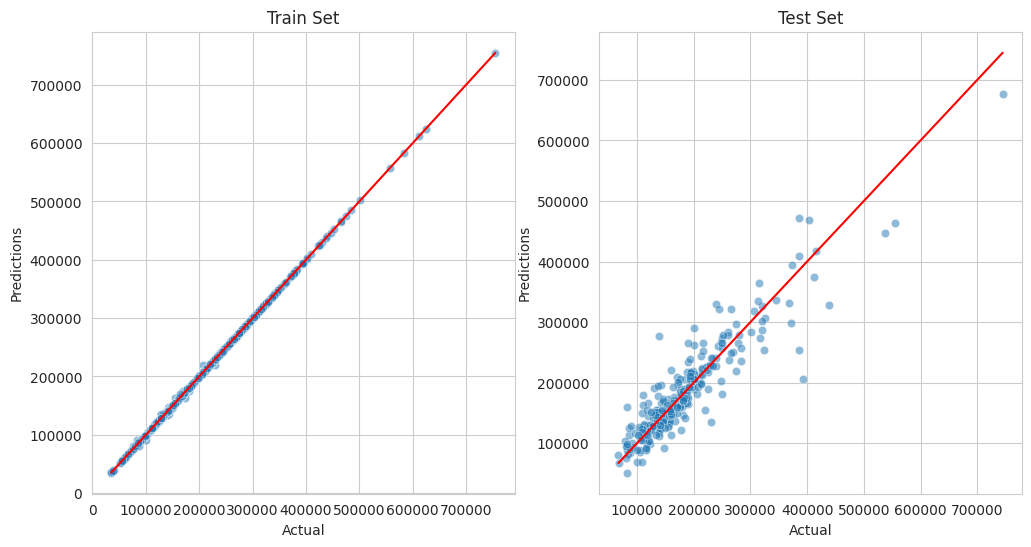

In [21]:
rgs_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
rgs_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

* upon evaluation of our model agaisnt our train and test sets we can see that we can consider it a success. Again our business requirement was an r2 score of atleast 0.75 agaisnt both the train and test sets which we have achieved.
    * Train r2_score = 1.0
    * Test r2_score = 0.847 

___

### PCA - Principle Component Analysis

* Having evaluate the model above, we may seek to improve it. One method of doing such is to use PCA. 
* PCA is a transformation of the data that attempts to find what features explain the most variance in the data.

In [22]:
pipeline = PipelineOptimisation(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:5])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


* The 17 components explain 100.0% of the data 



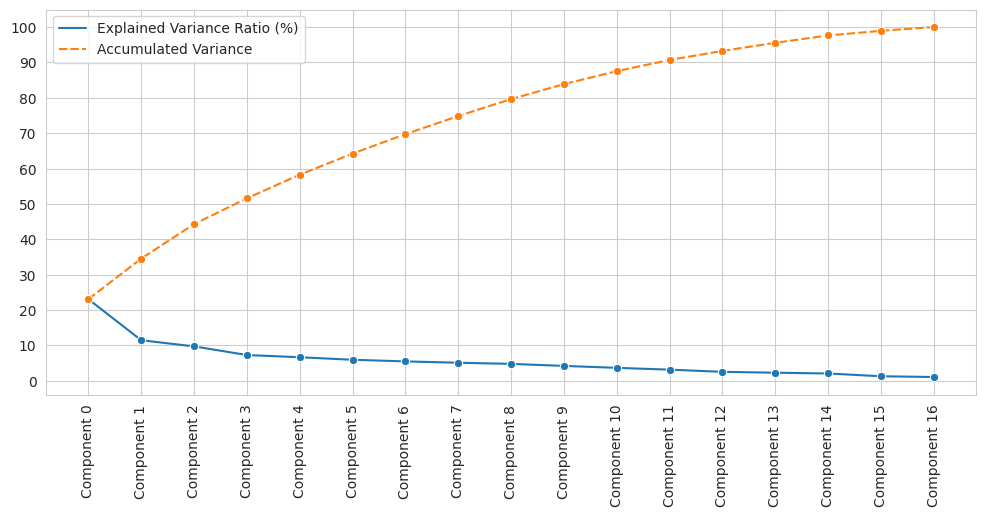

In [23]:
n_components = 17

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 10 components explain 83.86% of the data 



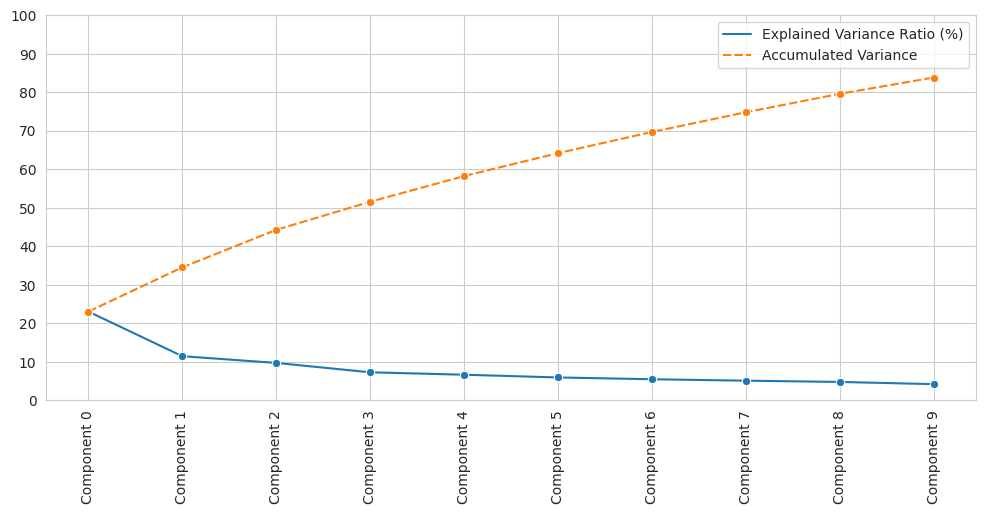

In [24]:
n_components = 10
pca_components_analysis(df_pca=df_pca,n_components=n_components)

* We can see that if we have reduce our components down to 10 we can still account for 83.86% of the varience within the data.
* We can rewrite a model that subs in our PCA with 10 components in place of 'feature_selection', we can then evaluate the new model and see if it has a more accurate return.

___

### New model applying the PCA

* We shall be repeating the above steps in order to evaluate the new model. 
* We shall use GridSearchCV and the base Hyperparameters to evaluate the most suitable algorithm.
* We shall then do an extensive Hyperparameter search in order to find the best Hyperparameters for the model.
* Next we shall assess feature importantance again
* Finally evaluating the pipelines performance.

In [25]:
def PipelineOptimisation(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),
        
        ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea',])),
        
        ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                            method="spearman",
                                                            threshold=0.6,
                                                            selection_method="cardinality")),

        ("feat_scaling", StandardScaler()),

        ("PCA",  PCA(n_components=10, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

In [26]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [27]:
models_pca_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_pca_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [28]:
pca_search = HyperparameterOptimizationSearch(models=models_pca_search, params=params_pca_search)
pca_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
grid_search_summary, grid_search_pipelines = pca_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.739636,0.776289,0.824007,0.030834
3,ExtraTreesRegressor,0.654777,0.770356,0.838946,0.063174
5,GradientBoostingRegressor,0.662331,0.759584,0.841463,0.061265
0,LinearRegression,0.651325,0.739797,0.809133,0.050853
6,XGBRegressor,0.647384,0.735005,0.813702,0.068178
4,AdaBoostRegressor,0.652805,0.719968,0.766504,0.039373
1,DecisionTreeRegressor,0.507158,0.622117,0.685415,0.061822


In [30]:
models_search_pca = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search_pca = {
    "RandomForestRegressor":{
        'model__n_estimators': [50,100,150,200,250,300],
        'model__max_depth': [2,8,16,32,None],
    }
}

In [31]:
search_pca = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search_pca)
search_pca.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [32]:
grid_search_summary, grid_search_pipelines = search_pca.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
27,RandomForestRegressor,0.73991,0.778324,0.830022,0.03356,None,200
21,RandomForestRegressor,0.73991,0.778324,0.830022,0.03356,32,200
29,RandomForestRegressor,0.737756,0.777455,0.827364,0.032958,None,300
23,RandomForestRegressor,0.737756,0.777455,0.827364,0.032958,32,300
26,RandomForestRegressor,0.739658,0.776995,0.82642,0.032341,None,150
20,RandomForestRegressor,0.739658,0.776995,0.82642,0.032341,32,150
28,RandomForestRegressor,0.737573,0.776684,0.828525,0.033734,None,250
22,RandomForestRegressor,0.737573,0.776684,0.828525,0.033734,32,250
19,RandomForestRegressor,0.739636,0.776289,0.824007,0.030834,32,100
25,RandomForestRegressor,0.739636,0.776289,0.824007,0.030834,None,100


In [33]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'RandomForestRegressor'

In [34]:
best_parameters_pca = grid_search_pipelines[best_model_pca].best_params_
best_parameters_pca

{'model__max_depth': 32, 'model__n_estimators': 200}

#### Things to note
* It is interesting that by implementing a PCA step into our pipleine ExtraTreesRegressor is no longer the best algorithm, When using PCA RandomForestRegressor is flagged as being the best.
* We also have a new Hyperparameters but as we have a new algorithm that is not surprising.
* we can also review our new r2 scores:
    * min r2_score = 0.73991
    * max r2_score = 0.830022
    * mean r2_score = 0.778324
    * std r2_score = 0.03356
* In contrast with the previous pipleine we can see that the min is much higher, the max and min are also lower, however std (standard deviation) is also reduced.

___

### Evaluate the new model

In [35]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model_pca].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea',
                                           'LotArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['BsmtUnfSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=10, random_state=0)),
                ('model',
                 RandomForestRegressor(max_depth=32, n_estimators=200,
                                       random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.968
Mean Absolute Error: 8519.332
Mean Squared Error: 198271160.558
Root Mean Squared Error: 14080.879


* Test Set
R2 Score: 0.729
Mean Absolute Error: 24012.229
Mean Squared Error: 1872913304.67
Root Mean Squared Error: 43277.168




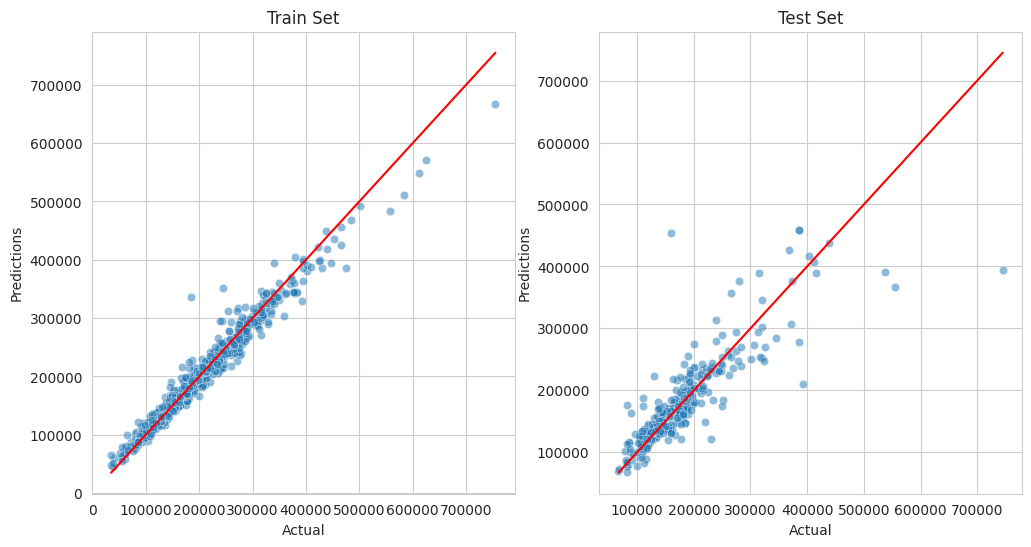

In [36]:
rgs_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline_pca)
rgs_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline_pca)

* Straight away we can see that this new model has not performed as well as the previous model that used feature scaling instead of PCA.
* This new model was not able to predict on the test set aswell as the previous.
* The results on the test set also fall below the 0.75 r2 score that was defined in the business case.

___

### Re Evaluate the Regression Pipeline with key features

* Subset the key features

In [37]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
618,1828,774,1828,Gd,2007,2007
870,894,308,894,TA,1962,1962
92,964,432,964,TA,1921,2006
817,1689,857,1689,Gd,2002,2002
302,1541,843,1541,Gd,2001,2002


* Re write the pipeline accounting for the changes that occur when only evaluating the key features.

In [38]:
def PipelineOptimisation(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['KitchenQual'])),
        
        ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base

* We shall use the best_model and best_parameters as defined when we evaluated the regression pipleine in the beggining.

In [39]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [40]:
best_parameters

{'model__max_depth': 32, 'model__n_estimators': 150}

In [41]:
params_search = {
    'ExtraTreesRegressor':  {
        'model__max_depth': [8,16,32],
        'model__n_estimators': [150,200,250,300]
        }
    }
params_search

{'ExtraTreesRegressor': {'model__max_depth': [8, 16, 32],
  'model__n_estimators': [150, 200, 250, 300]}}

In [42]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
8,ExtraTreesRegressor,0.673902,0.799017,0.858198,0.072068,32,150
9,ExtraTreesRegressor,0.671752,0.797543,0.857541,0.07323,32,200
4,ExtraTreesRegressor,0.668054,0.796646,0.859521,0.074253,16,150
11,ExtraTreesRegressor,0.668124,0.79612,0.858951,0.073569,32,300
7,ExtraTreesRegressor,0.6671,0.795783,0.858243,0.074575,16,300
5,ExtraTreesRegressor,0.668376,0.795678,0.858721,0.073892,16,200
10,ExtraTreesRegressor,0.668715,0.795473,0.858548,0.074341,32,250
3,ExtraTreesRegressor,0.669446,0.795263,0.852911,0.072511,8,300
1,ExtraTreesRegressor,0.673303,0.795063,0.853108,0.071594,8,200
2,ExtraTreesRegressor,0.671339,0.79477,0.85288,0.071831,8,250


In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [45]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=32, n_estimators=150,
                                     random_state=0))])

* Re-assess key feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
Index(['1stFlrSF', 'GarageArea', 'GrLivArea', 'KitchenQual', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


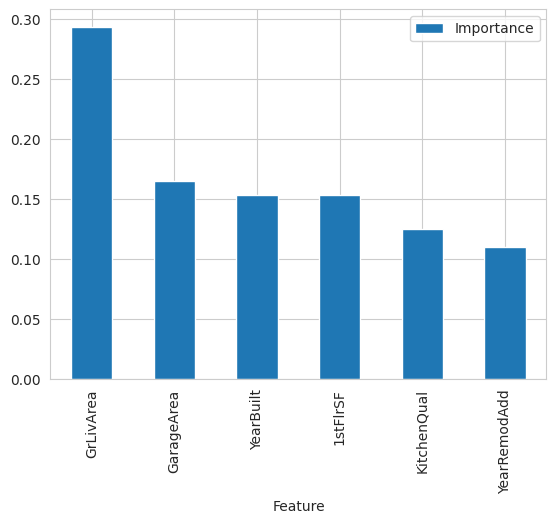

In [46]:
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* Re assess the model performance

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 138.289
Mean Squared Error: 947914.048
Root Mean Squared Error: 973.609


* Test Set
R2 Score: 0.847
Mean Absolute Error: 21292.305
Mean Squared Error: 1053381483.713
Root Mean Squared Error: 32455.839




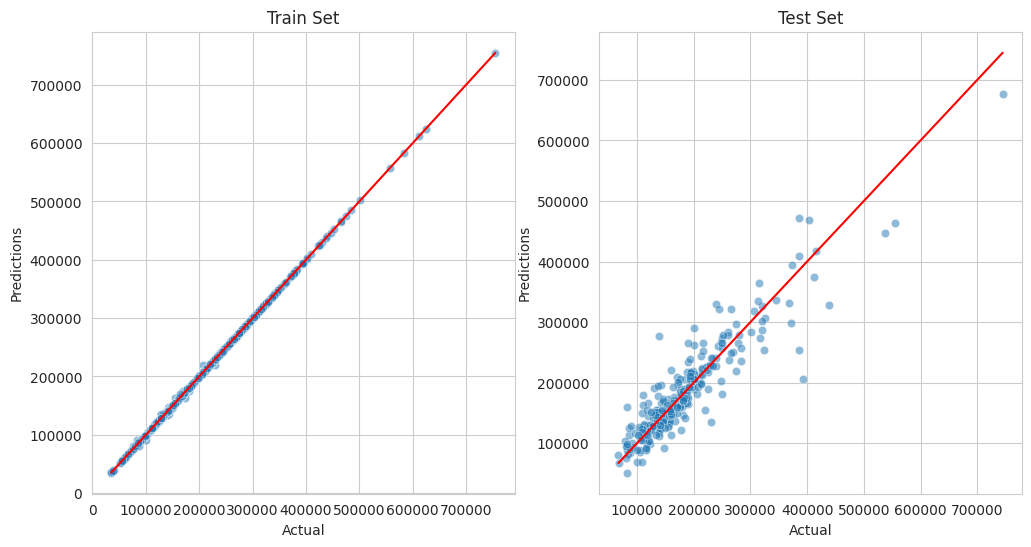

In [47]:
rgs_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
rgs_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

* We can see that by refitting the pipeline to only consider the key features we do not lose any accuracy in our model. We are still exceeding the business requirement of an r2_score of 0.75 on both the train and test set.

___

## Save the datasets and the model

* We need to save our final pipeline in order to present it in a usable state on the dashboard. We also need to save our train and test data in order to evaluate the model on the dashboard. We shall complete both these steps now

In [48]:
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

* Save the train sets features and targets

In [49]:
print(X_train.shape)
X_train.head()

(1168, 6)


,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
618,1828,774,1828,Gd,2007,2007
870,894,308,894,TA,1962,1962
92,964,432,964,TA,1921,2006
817,1689,857,1689,Gd,2002,2002
302,1541,843,1541,Gd,2001,2002


In [50]:
print(y_train.shape)
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [51]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [52]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

* Repeat and save the Test sets

In [53]:
print(X_test.shape)
X_test.head()

(292, 6)


,1stFlrSF,GarageArea,GrLivArea,KitchenQual,YearBuilt,YearRemodAdd
529,2515,484,2515,TA,1957,1975
491,958,240,1578,Fa,1941,1950
459,979,352,1203,Gd,1950,1950
279,1156,505,2022,TA,1977,1977
655,525,264,1092,TA,1971,1971


In [54]:
print(y_test.shape)
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [55]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [56]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

* Save the pipeline

In [57]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=32, n_estimators=150,
                                     random_state=0))])

In [58]:

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/best_regressor_pipeline.pkl']

* Save the graphics to be applied to the dashboard.

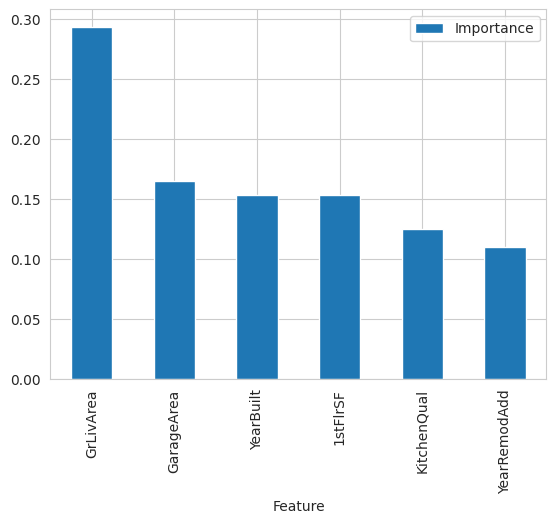

In [59]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

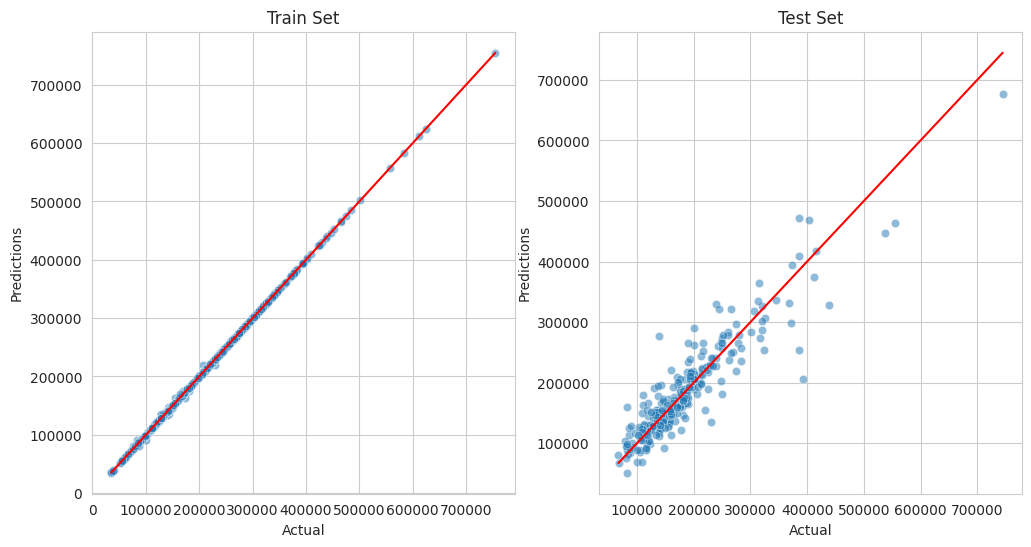

In [60]:
# regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)
pred_train = best_regressor_pipeline.predict(X_train)
pred_test = best_regressor_pipeline.predict(X_test)
alpha_scatter=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.savefig(f'{file_path}/regression_evaluation_plots.png', bbox_inches='tight')

___

### Conclusion

* In the end the regressor model that used feature selection was determined to be the most optimised model, this was due to the drop in accuaracy that occured when we implemented the PCA (Principle Component Analysis).
* Our goal as set in the business requirements was to meet or exceed an r2_score of 0.75 on both the train and test set. When using PCA this was not the case with the test set, hence it could not be used further. The model that utilised feature selection however performed ammicably and exceeded our business requirements with an r2_score of 1.0 on the train set and 0.847 on the test set. As such we may consider our modelling and evaluation a success and we can move on to creating our dashboard.